# EP #3 - Geração de Mosaicos

Renato Sérgio Lopes Júnior \
2020667570


In [1]:
import os
import cv2
import numpy as np

# pip install opencv-contrib-python==4.4.0.44

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Read images

In [2]:
def read_images(path="imgs/"):
    imgs = []
    for img_name in ['img1.jpg', 'img2.jpg', 'img3.jpg', 'img4.jpg', 'img5.jpg', 'img6.jpg']:
        img = cv2.imread(os.path.join(path, img_name))
#         img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2), interpolation = cv2.INTER_AREA)
        imgs.append(img)
    return imgs

In [3]:
imgs = read_images()

## Define keypoint detection/description/matching methods

In [4]:
MAX_FEATURES = 20000

sift = cv2.SIFT_create(nfeatures=MAX_FEATURES)
fast = cv2.FastFeatureDetector_create(20)
orb = cv2.ORB_create(nfeatures=MAX_FEATURES)
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

def get_keypoints(img, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp = sift.detect(gray, None)
    elif alg == 'fast':
        kp = fast.detect(gray, None)
    elif alg == 'orb':
        kp = orb.detect(img, None)
    else:
        raise ValueError('Invalid algorithm')
    return kp

def get_descriptor(img, kp, alg):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if alg == 'sift':
        kp, des = sift.compute(gray, kp)
    elif alg == 'brief':
        kp, des = brief.compute(img, kp)
    elif alg == 'orb':
        kp, des = orb.compute(img, kp)
    else:
        raise ValueError('Invalid algorithm')
    return kp, des

def get_matches(desc1, desc2, alg):
    if alg == 'brief' or alg == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(desc1, desc2)
    elif alg == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(desc1, desc2)
    else:
        raise ValueError('Invalid algorithm')
    return matches

def get_pairs(kp0, kp1, matches):
    pairs_src, pairs_dst = [], []
    for m in matches:
        pairs_src.append(kp0[m.queryIdx].pt)
        pairs_dst.append(kp1[m.trainIdx].pt)
    pairs_src = np.float32(pairs_src).reshape(-1,1,2)
    pairs_dst = np.float32(pairs_dst).reshape(-1,1,2)
    return pairs_src, pairs_dst

## Computing Homography

In [21]:
def compute_homograpy(img0, img1, alg_detect, alg_descr):
    # Detect keypoints
    print(f"Detect {alg_detect} keypoints for img0...")
    kp0 = get_keypoints(img0, alg_detect)
    print(f"Detected {alg_detect} keypoints for img0.")
    print(f"Detect {alg_detect} keypoints for img1...")
    kp1 = get_keypoints(img1, alg_detect)
    print(f"Detected {alg_detect} keypoints for img1.")
    # Get keypoints descriptions
    kp0, desc0 = get_descriptor(img0, kp0, alg_descr)
    kp1, desc1 = get_descriptor(img1, kp1, alg_descr)
    # Get matches
    matches = get_matches(desc0, desc1, alg_descr)
    # Get pairs of correspondence
    pairs_src, pairs_dst = get_pairs(kp0, kp1, matches)
    # Compute Homography
    H, mask = cv2.findHomography(pairs_src, pairs_dst, cv2.RANSAC)
    return H, mask

DETECTOR, DESCRIPTOR = 'sift', 'sift'
H_all = {}

MID_IMG = 3
for i in range(0, 6):
    if i != MID_IMG:
        H, _ = compute_homograpy(imgs[i], imgs[MID_IMG], DETECTOR, DESCRIPTOR)
        H_all[i] = H
    else:
        H_all[i] = np.identity(3)

Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.
Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.
Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.
Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.
Detect sift keypoints for img0...
Detected sift keypoints for img0.
Detect sift keypoints for img1...
Detected sift keypoints for img1.


In [37]:
# def warpPerspective(img_final, img, H):
#     H = np.linalg.inv(H)
#     h, w = img.shape[:2]
    
#     pt0 = np.dot(H, np.array([0,0,1]))
#     pt0 = pt0/pt0[-1]
    
#     H[-1][0] += abs(pt0[0])
#     H[-1][1] += abs(pt0[1])
    
#     ds = np.dot(H, np.array([w,h,1]))
#     offsetx = int(abs(pt0[0]))
#     offsety = int(abs(pt0[1]))
        
#     dsize = (int(ds[0]) + offsetx, int(ds[1]) + offsety)
    
#     result = cv2.warpPerspective(img, H, dsize)
#     img_final[offsety:int(result.shape[0])+offsety, offsetx:int(result.shape[1]) + offsetx] = result


def warpPerspective(img_final, img, H):
    h, w = img.shape[:2]
    pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts_transformed = cv2.perspectiveTransform(pts, H)
    [xmin, ymin] = np.int32(pts_transformed.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_transformed.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    result = cv2.warpPerspective(img, Ht.dot(H), (xmax-xmin, ymax-ymin))
    print(H)
    t = [-img_xmin, -img_ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]])
    offset = np.int32(cv2.perspectiveTransform(np.float32([[0,0]]).reshape(-1, 1, 2), Ht.dot(H)))[0][0]
    print(H)
    print("t", t)
    print("o", offset)
    img_final[offset[1]:int(result.shape[0])+offset[1], offset[0]:int(result.shape[1]) + offset[0]] = result

# def warpPerspective(img_final, img, H):
#     h, w = img.shape[:2]
#     pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
#     pts_transformed = cv2.perspectiveTransform(pts, H)
#     [xmin, ymin] = np.int32(pts_transformed.min(axis=0).ravel() - 0.5)
#     [xmax, ymax] = np.int32(pts_transformed.max(axis=0).ravel() + 0.5)
#     offset = cv2.perspectiveTransform(np.float32([[0,0]]).reshape(-1, 1, 2), H)[0][0]
#     H[0][-1] += abs(offset[0])
#     H[1][-1] += abs(offset[1])
#     result = cv2.warpPerspective(img, H, (xmax-xmin, ymax-ymin))
#     return result
# #     offset = np.int32(cv2.perspectiveTransform(np.float32([[0,0]]).reshape(-1, 1, 2), Ht.dot(H)))[0][0]
# #     img_final[offset[1]:int(result.shape[0])+offset[1], offset[0]:int(result.shape[1]) + offset[0]] = result


### Transforming Images

{0: [-12273, -2723, 1774, 4783], 1: [-5854, -1559, 2881, 4028], 2: [-2477, -653, 3904, 3341], 3: [0, 0, 5312, 2988], 4: [1343, -208, 6793, 3036], 5: [2207, -1316, 10355, 3602]}


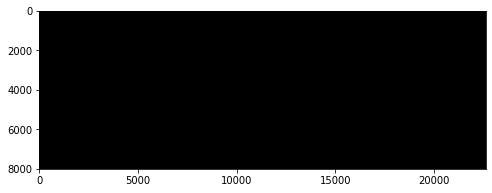

In [7]:
img_sizes = {}
img_xmax, img_ymax = -np.inf, -np.inf
img_xmin, img_ymin = np.inf, np.inf
for i in range(0, 6):
    h, w = imgs[i].shape[:2]
    pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts_transformed = cv2.perspectiveTransform(pts, H_all[i])
    [xmin, ymin] = np.int32(pts_transformed.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_transformed.max(axis=0).ravel() + 0.5)
    img_sizes[i] = [xmin, ymin, xmax, ymax]
    if xmax > img_xmax:
        img_xmax = xmax
    if xmin < img_xmin:
        img_xmin = xmin
    if ymax > img_ymax:
        img_ymax = ymax
    if ymin < img_ymin:
        img_ymin = ymin
        
print(img_sizes)

img_final = np.zeros((img_ymax-img_ymin+500, img_xmax-img_xmin+1, 3), dtype=np.uint8)

fig = plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.show()

[[ 2.65285450e+00 -3.83554302e-01 -9.28982700e+03]
 [ 6.69701582e-01  2.27232667e+00 -2.72310903e+03]
 [ 3.21363424e-04 -5.00982570e-05  1.00000000e+00]]
[[ 2.65285450e+00 -3.83554302e-01 -9.28982700e+03]
 [ 6.69701582e-01  2.27232667e+00 -2.72310903e+03]
 [ 3.21363424e-04 -5.00982570e-05  1.00000000e+00]]
t [12273, 2723]
o [2983    0]


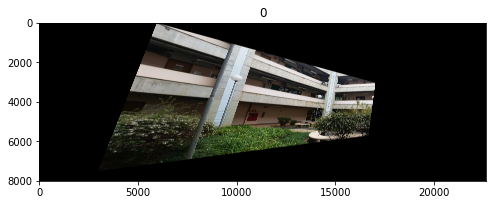

[[ 2.22838926e+00 -1.47643621e-01 -5.52922072e+03]
 [ 4.01859191e-01  1.89648909e+00 -1.55859351e+03]
 [ 2.23974050e-04  6.67101216e-06  1.00000000e+00]]
[[ 2.22838926e+00 -1.47643621e-01 -5.52922072e+03]
 [ 4.01859191e-01  1.89648909e+00 -1.55859351e+03]
 [ 2.23974050e-04  6.67101216e-06  1.00000000e+00]]
t [12273, 2723]
o [6743 1164]


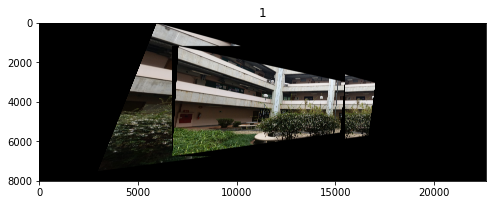

[[ 1.56097474e+00 -6.47726587e-02 -2.29797867e+03]
 [ 1.89391410e-01  1.34342248e+00 -6.53310081e+02]
 [ 1.00777457e-04  2.01296462e-06  1.00000000e+00]]
[[ 1.56097474e+00 -6.47726587e-02 -2.29797867e+03]
 [ 1.89391410e-01  1.34342248e+00 -6.53310081e+02]
 [ 1.00777457e-04  2.01296462e-06  1.00000000e+00]]
t [12273, 2723]
o [9975 2069]


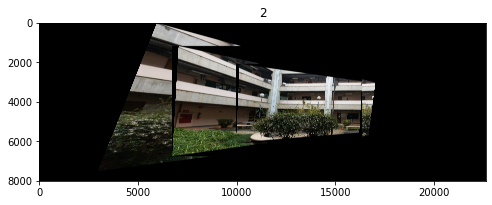

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t [12273, 2723]
o [12273  2723]


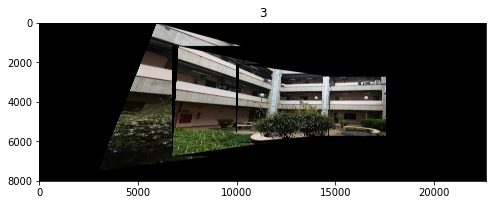

[[ 7.50644459e-01  2.24330898e-02  1.34430256e+03]
 [-7.82026882e-02  8.64262046e-01  2.45535807e+02]
 [-3.42703603e-05 -7.77293783e-06  1.00000000e+00]]
[[ 7.50644459e-01  2.24330898e-02  1.34430256e+03]
 [-7.82026882e-02  8.64262046e-01  2.45535807e+02]
 [-3.42703603e-05 -7.77293783e-06  1.00000000e+00]]
t [12273, 2723]
o [13617  2968]


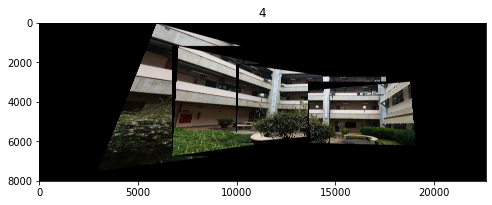

[[ 5.20167684e-01  5.99407833e-02  2.20800549e+03]
 [-1.91937086e-01  8.28907230e-01  3.34232896e+02]
 [-9.02425669e-05 -7.78892687e-06  1.00000000e+00]]
[[ 5.20167684e-01  5.99407833e-02  2.20800549e+03]
 [-1.91937086e-01  8.28907230e-01  3.34232896e+02]
 [-9.02425669e-05 -7.78892687e-06  1.00000000e+00]]
t [12273, 2723]
o [14481  3057]


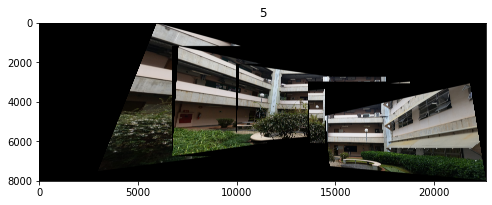

In [39]:
for i in range(0, 6):
    H = H_all[i]
    warpPerspective(img_final, imgs[i], H)
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    plt.title(str(i))
    plt.show()